# Elo Merchant - Kaggle Competition

## Setting up our environment

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm # to generate qqplot
import seaborn as sns # to perform nice vizualisation for EDA

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Files we have for this competition

So we are given the above files. The description of the files are : 

**train.csv** - the training set

**test.csv** - the test set

**sample_submission.csv** - a sample submission file in the correct format - contains all card_ids you are expected to predict for.

**historical_transactions.csv** - up to 3 months' worth of historical transactions for each card_id

**merchants.csv** - additional information about all merchants / merchant_ids in the dataset.

**new_merchant_transactions.csv** - two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.

First let's explore the train and test set.

In [41]:
#Loading the different datasets
train = pd.read_csv("train.csv", parse_dates=["first_active_month"], error_bad_lines=False)
test = pd.read_csv("test.csv", parse_dates=["first_active_month"])

In [26]:
merchants = pd.read_csv('merchants.csv')
hist_transact = pd.read_csv("historical_transactions.csv")
new_transact = pd.read_csv("new_merchant_transactions.csv")
sample_sub = pd.read_csv("sample_submission.csv")


## Getting to know our data - Exploratory Data Analysis

### Train/Test data set Exploration

In [3]:
print("Shape of train set is", train.shape)
print("Shape of test set is", test.shape)

Shape of train set is (201917, 6)
Shape of test set is (123623, 5)


In [4]:
# Have more information on columns in train/test datasets
pd.read_excel('Data_Dictionary.xlsx', sheet_name='train')

# Here we understand better what feature 1/2/3 are : anonymized categorical features

,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


In [5]:
# gather information on types, N/A values etc
train.info()
test.info()

train.describe()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
first_active_month    123622 non-null datetime64[ns]
card_id               123623 non-null object
feature_1             123623 non-null int64
feature_2             123623 non-null int64
feature_3             123623 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 4.7+ MB


,feature_1,feature_2,feature_3
count,123623.00000,123623.000000,123623.000000
mean,3.10926,1.741796,0.564377
std,1.18911,0.749195,0.495840
min,1.00000,1.000000,0.000000
25%,2.00000,1.000000,0.000000
50%,3.00000,2.000000,1.000000
75%,4.00000,2.000000,1.000000
max,5.00000,3.000000,1.000000


In [6]:
train.head()
# test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


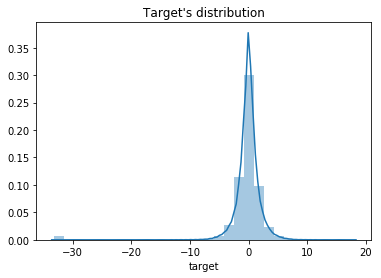

Number of target values below -30 is  2207


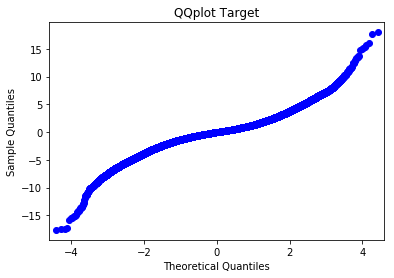

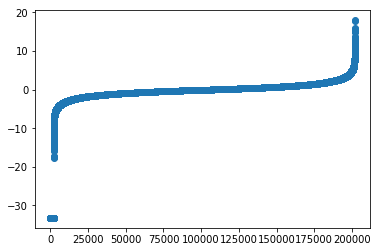

In [7]:
# Understand distribution of Target Score with a histogram. We can see that it looks like normally distributed except for the > -30 scores.
# there are consequent amount of targets below -30. We might have to adress these in a specific way.
sns.distplot(train.target, bins = 30)
plt.title("Target's distribution")
plt.show()

print("Number of target values below -30 is ", sum(train.target<-30))

# Verification with QQplot : distribution isn't perfectly normally distributed. We could think of transformation to improve it.
sm.qqplot(train.target[train.target>-30])
plt.title("QQplot Target")
plt.show()

# Scatter plot
plt.scatter(range(train.shape[0]), np.sort(train.target))
plt.show()

In [8]:
# convert Features into categorical data in test and train dataset
train.feature_1 = train.feature_1.astype('int').astype('category')
train.feature_2 = train.feature_2.astype('int').astype('category')
train.feature_3 = train.feature_3.astype('int').astype('category')

test.feature_1 = train.feature_1.astype('int').astype('category')
test.feature_2 = train.feature_2.astype('int').astype('category')
test.feature_3 = train.feature_3.astype('int').astype('category')

# see changes
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null category
feature_2             201917 non-null category
feature_3             201917 non-null category
target                201917 non-null float64
dtypes: category(3), datetime64[ns](1), float64(1), object(1)
memory usage: 5.2+ MB


/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


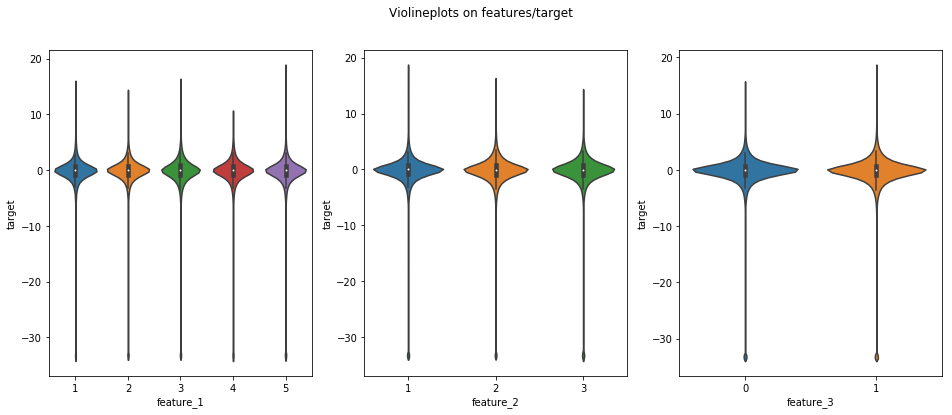

In [9]:
# analyse distribution of anonymised features

# Violinplot analysis : same as boxplot but also enables to see the probability of a specific value. 
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
plt.suptitle('Violineplots on features/target');

# feature_1
sns.violinplot(train.feature_1, train.target, ax = ax[0], title = "feature_1")
# feature_2
sns.violinplot(train.feature_2, train.target, ax = ax[1], title = "feature_2")
# feature_3
sns.violinplot(train.feature_3, train.target, ax = ax[2], title = "feature_3")

plt.show()

# distribution for feature_1/2/3 is looking similar. This suggests that those features might not be really usefull to predict target.
# Each of those features seems also centered on 0, maybe issued from a normal distribution.
# Solution to this absence of real differenciator can be feature engineering.

#### Comparing distribution between train and test data

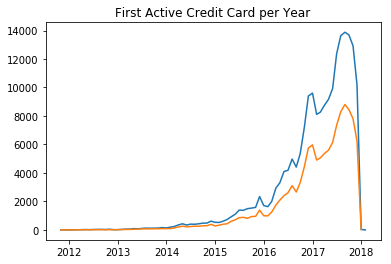

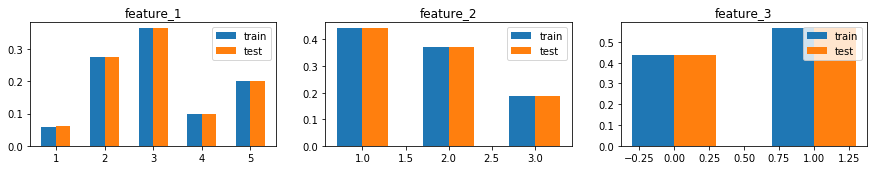

In [10]:
# We can see that the first_active_month pattern is the same in the test and train dataset which is good news.
sns.lineplot(train.first_active_month.value_counts().sort_index().index, train.first_active_month.value_counts().sort_index().values)
sns.lineplot(test.first_active_month.value_counts().sort_index().index, test.first_active_month.value_counts().sort_index().values)
plt.title("First Active Credit Card per Year")
plt.show()

plt.figure(figsize=[15,5])

# comparing proportion of each category in test vs train. This is reassuring
for num, name in enumerate(["feature_1","feature_2","feature_3"]):
    plt.subplot(2,3,num+1)
    plt.bar((train[name].value_counts()/train.shape[0]).index, (train[name].value_counts()/train.shape[0]), label='train', width=-0.3, align='edge')
    plt.bar((test[name].value_counts()/test.shape[0]).index, (test[name].value_counts()/test.shape[0]), label='test', width=0.3, align='edge')
    plt.legend()
    plt.title(name)

plt.show()

#### Finding patterns in outliers

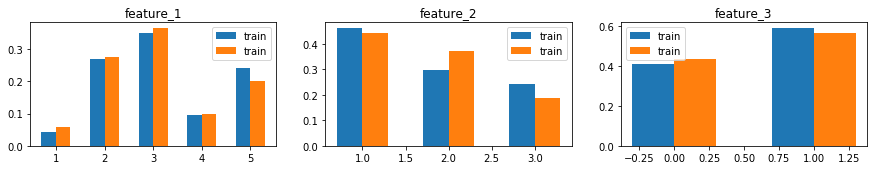

In [11]:
# comparing proportion of each category in test vs train. This is reassuring
plt.figure(figsize=[15,5])

for num, name in enumerate(["feature_1","feature_2","feature_3"]):
    plt.subplot(2,3,num+1)
    plt.bar((train[train.target < -30][name].value_counts()/train[train.target < -30].shape[0]).index, (train[train.target < -30][name].value_counts()/train[train.target < -30].shape[0]), label='train', width=-0.3, align='edge')
    plt.bar((train[train.target > -30][name].value_counts()/train[train.target > -30].shape[0]).index, (train[train.target > -30][name].value_counts()/train[train.target > -30].shape[0]), label='train', width=0.3, align='edge')
    plt.legend()
    plt.title(name)

plt.show()

#### Analysing correlations

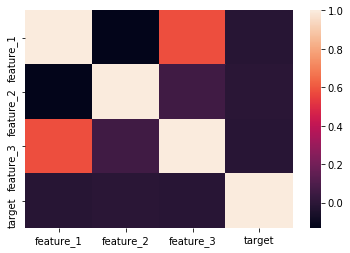

In [12]:
# Convert back to 'int' for correlations analysis and scatter matrix
train['feature_1'] = train['feature_1'].astype('int')
train['feature_2'] = train['feature_2'].astype('int')
train['feature_3'] = train['feature_3'].astype('int')

train.describe()

# It seems most correlated feature to target is feature_3 
corr = train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# corr.style.background_gradient().set_precision(2)
plt.show()

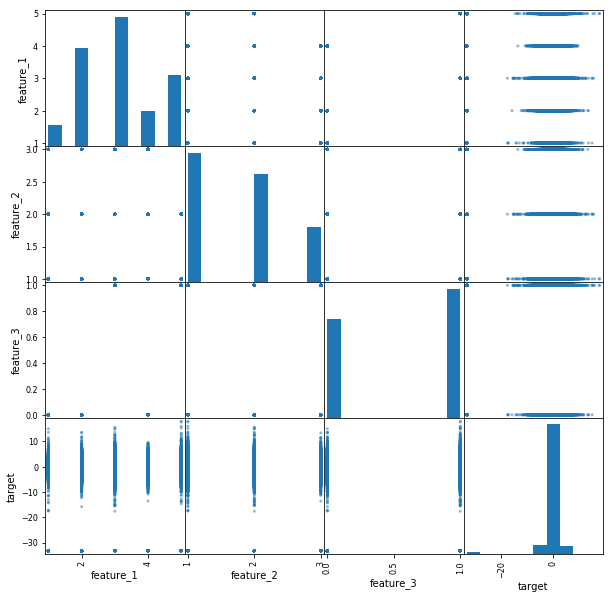

In [13]:
# Summary of most of above studies to spot quickly if there are any obvious information we haven't seen

from pandas.plotting import scatter_matrix
scatter_matrix(train[['feature_1','feature_2','feature_3', 'target']], figsize = [10,10])
plt.show()

At the end of the train/test analysis, we didn't find much useful information to perform our predictions. We will have to dig further in other datasets and most probably build a lot of new features manually that might be relevant for the prediction.

We did see that train/test datasets were part of the same pool of observations (could have been selected randomly for instance) and have for most features the same distribution. 

### Merchants data analysis

Now, let take a look at the merchants. From the dataset's describtion:

-------------


merchant_id: Unique merchant identifier

merchant_group_id: Merchant group (anonymized )

merchant_category_id: Unique identifier for merchant category (anonymized )

subsector_id: Merchant category group (anonymized )

numerical_1: anonymized measure

numerical_2: anonymized measure

category_1: anonymized category

most_recent_sales_range: Range of revenue (monetary units) in last active month --> A > B > C > D > E

most_recent_purchases_range: Range of quantity of transactions in last active month --> A > B > C > D > E

avg_sales_lag3: Monthly average of revenue in last 3 months divided by revenue in last active month

avg_purchases_lag3: Monthly average of transactions in last 3 months divided by transactions in last active month

active_months_lag3: Quantity of active months within last 3 months

avg_sales_lag6: Monthly average of revenue in last 6 months divided by revenue in last active month

avg_purchases_lag6: Monthly average of transactions in last 6 months divided by transactions in last active month

active_months_lag6: Quantity of active months within last 6 months

avg_sales_lag12: Monthly average of revenue in last 12 months divided by revenue in last active month

avg_purchases_lag12: Monthly average of transactions in last 12 months divided by transactions in last active month

active_months_lag12: Quantity of active months within last 12 months

category_4: anonymized category

city_id: City identifier (anonymized )

state_id: State identifier (anonymized )

category_2: anonymized category

#### Cleaning outliers 

In the following section, we realized that there where outliers making it impossible to visualize correctly correlations. We decided to remove those for now.

In [14]:
# replacing inf values with nan
merchants.replace([-np.inf, np.inf], np.nan, inplace=True)

In [15]:
no_outliers_merchants = merchants[(merchants['numerical_1'] < 0.1) & (merchants['numerical_2'] < 0.1) &
                                  (merchants['avg_sales_lag3'] < 5) & (merchants['avg_purchases_lag3'] < 5) &
                                  (merchants['avg_sales_lag6'] < 10) & (merchants['avg_purchases_lag6'] < 10) &
                                  (merchants['avg_sales_lag12'] < 10) & (merchants['avg_purchases_lag12'] < 10)]

no_outliers_merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.6875,12,N,22,16,1.0
25,M_ID_2be211b847,35,456,21,-0.057471,-0.057471,N,E,E,1.00,...,1.00,1.000000,1,1.00,1.0000,1,N,85,8,3.0
41,M_ID_c5e6e7c15c,24930,606,17,-0.057471,-0.057471,N,E,E,2.77,...,2.77,1.000000,2,2.77,1.0000,2,Y,69,9,1.0
52,M_ID_44384f4b59,8533,544,29,-0.057471,-0.057471,N,E,E,1.00,...,1.00,1.000000,1,1.00,1.0000,1,N,-1,-1,NaN
53,M_ID_c0b712e11a,35,823,25,-0.057471,-0.057471,N,E,E,1.00,...,1.00,1.000000,1,1.00,1.0000,1,N,231,9,1.0


In [16]:
categ_col = ['active_months_lag6','active_months_lag3','most_recent_sales_range', 'most_recent_purchases_range','category_1','active_months_lag12','category_4', 'category_2']

numeric_col = ['numerical_1', 'numerical_2','merchant_group_id','merchant_category_id','avg_sales_lag3', 'avg_purchases_lag3', 'subsector_id', 'avg_sales_lag6', 'avg_purchases_lag6', 'avg_sales_lag12', 'avg_purchases_lag12']

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

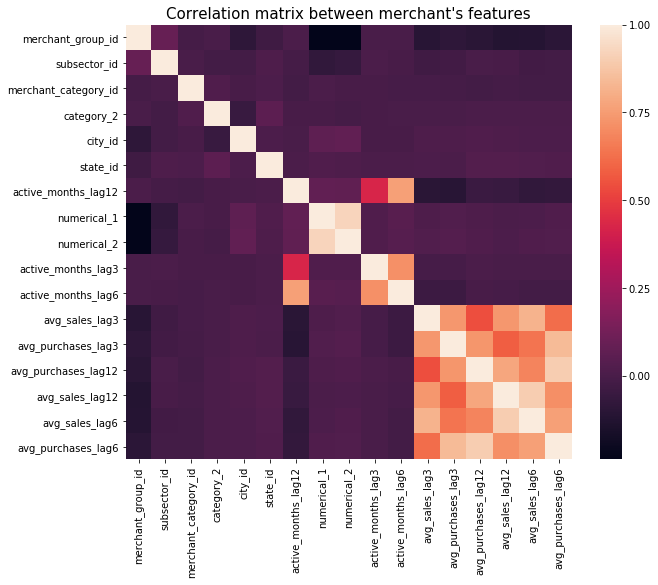

In [21]:
# Correlation matrix for no outlier merchants dataset ordered by correlation
# if we use the merchants dataset, the correlations are less clear

plt.figure(figsize=[10, 8])
corr = no_outliers_merchants.corr()
corr = no_outliers_merchants[list((corr).sum().sort_values().index)].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Correlation matrix between merchant\'s features', fontsize=15)
plt.show()


#### The corr matrix reveals some interesting relationships:

numerical_1 and numerical_2 are highly correlated

As we could expect, avg_sales and avg_purchases in the last 3, 6, and 12 months are highly correlated

mechant_group_id is loosely correlated with numerical_1, 2, city_id, and sales statistics. Interestingly, merchant_category_id shows little correlation with merchant_group_id, city_id, or really anything else.

category_1 is loosely correlated with the merchant's location (city_id and state_id)

category_1 and category_2 are never not NaNs at the same time

#### Let's analyse variables most correlated with each other

['avg_sales_lag12',
 'avg_sales_lag6',
 'avg_purchases_lag12',
 'avg_purchases_lag3',
 'avg_purchases_lag6',
 'avg_sales_lag3']


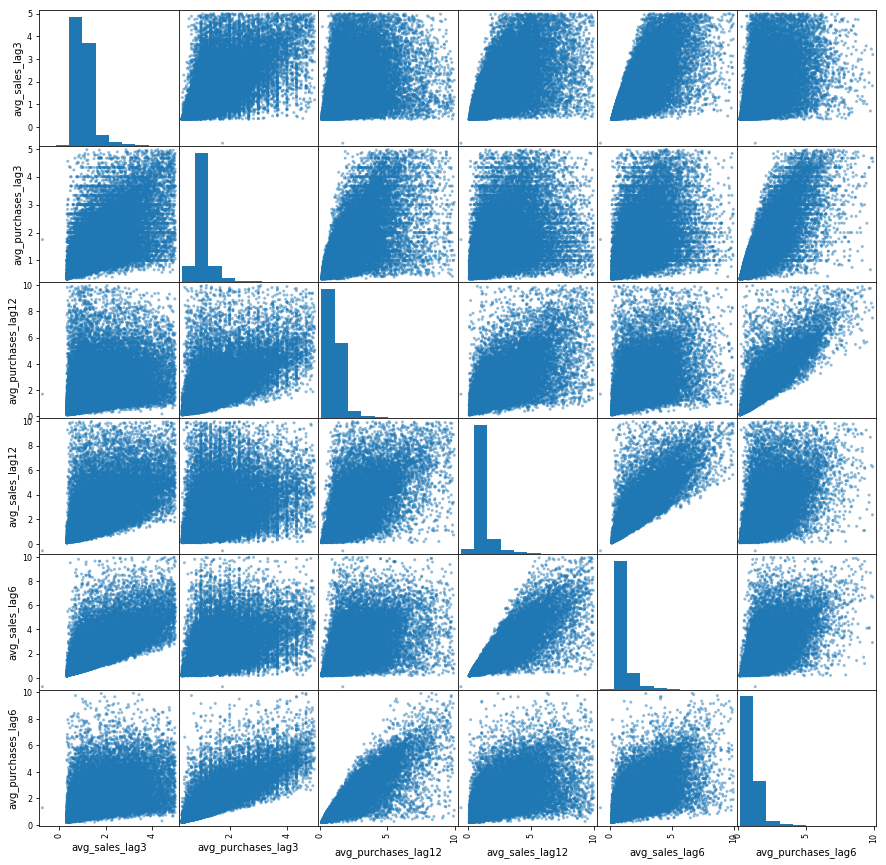

In [22]:
most_corr_col = list((corr).sum().sort_values().index)[-6:]

scatter_matrix(no_outliers_merchants[most_corr_col], figsize = [15,15])
plt.show()

# Nothing really surprising, nor interesting here. Classic correlation scheme. 

#### Let's analyse variables least correlated with each other

['active_months_lag12',
 'numerical_1',
 'numerical_2',
 'active_months_lag3',
 'active_months_lag6']

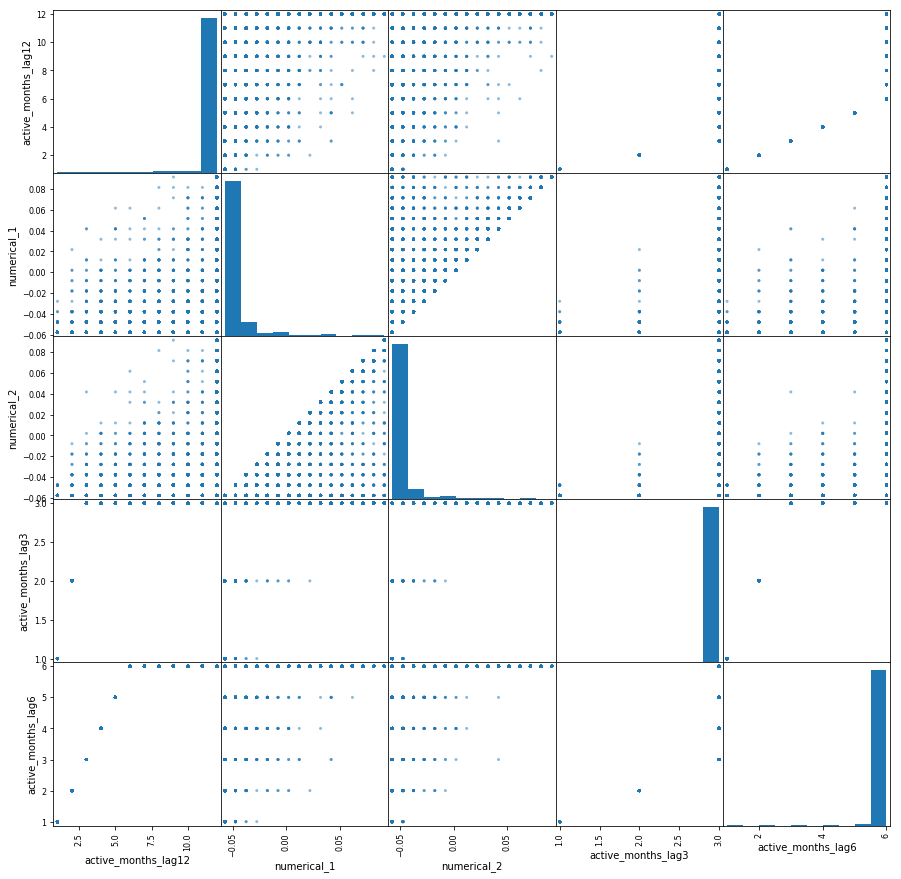

In [23]:
medium_corr_col = list((corr).sum().sort_values().index)[6:11]

scatter_matrix(no_outliers_merchants[medium_corr_col], figsize = [15,15])
plt.show()

Interesting pieces of information here : 
- numerical_2 is never higher than numerical_1
- As we progress in active months, numerical_1/2 are rising in average
- We have the same data in active month 3,6 and 12. 3 and 6 are truncated versions of the 12 one.
- Merchants with less than 12 months are those that recently opened their business.

### Historical Transactions data analysis

Now, let take a look at the transactions dataset. From the dataset's description:



In [2]:
hist_transact.head()

NameError: name 'hist_transact' is not defined

In [25]:
hist_transact.describe()

,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.645950e+07,2.911236e+07,2.911236e+07
mean,1.293256e+02,6.484954e-01,4.810130e+02,-4.487294e+00,3.640090e-02,2.194578e+00,1.056679e+01,2.684839e+01
std,1.042563e+02,2.795577e+00,2.493757e+02,3.588800e+00,1.123522e+03,1.531896e+00,6.366927e+00,9.692793e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.300000e+01,-7.469078e-01,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,5.300000e+01,0.000000e+00,3.070000e+02,-7.000000e+00,-7.203559e-01,1.000000e+00,9.000000e+00,1.900000e+01
50%,9.000000e+01,0.000000e+00,4.540000e+02,-4.000000e+00,-6.883495e-01,1.000000e+00,9.000000e+00,2.900000e+01
75%,2.120000e+02,1.000000e+00,7.050000e+02,-2.000000e+00,-6.032543e-01,3.000000e+00,1.600000e+01,3.400000e+01
max,3.470000e+02,9.990000e+02,8.910000e+02,0.000000e+00,6.010604e+06,5.000000e+00,2.400000e+01,4.100000e+01


city_id / state_id / subsector_id : basically anonimizing categorical data

installments : huge difference between 75% and max. Which might indicate presence of outliers.

merchant_category_id : min is negative which might me a specific category. Looks like there are 891 category.

purchase_amount : huge difference between 75% and max. Which might indicate presence of outliers.

category_2 : Looks like there are 5 category. 

In [26]:
hist_transact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


Convert these variables into category so save some memory space

city_id                 int64 -> category

installments            int64 -> category

merchant_category_id    int64 -> category

month_lag               int64 -> category

state_id                int64 -> category

subsector_id            int64 -> category

['purchase_date'] =  pd.to_datetime(historical_tx_df.purchase_date, format='%Y%m%d %H:%M:%S')


https://www.kaggle.com/rpalsaxena/preprocessing-of-29m-transaction-records

## New Merchant Transactions data analysis

Now, let take a look at the new merchant transactions dataset. From the dataset's description:

In [27]:
# Convert category values


## Features engineering

We here are going to create new features with the additional data we have then merge it with the train/test dataset.

The goal is the strenghten our prediction of loyalty. That's why we first chose to focus on the purchase amount variable and the date the client made his first purchase.

In [42]:
#Creation of new features according to the amount spent
df1 = hist_transact.groupby("card_id")
df1 = df1["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max','size']).reset_index()
df1.columns = ["card_id", "sum_hist_transact", "mean_hist_transact", "std_hist_transact", "min_hist_transact", "max_hist_transact","num_hist_transactions"]

#Updating the train/test
train = pd.merge(train, df1, on="card_id", how="left")
test = pd.merge(test, df1, on="card_id", how="left")


# Counting the number of new transaction per merchant
#df = new_transact.groupby("card_id")
#df = df["purchase_amount"].size().reset_index()
#df.columns = ["card_id", "num_merch_transactions"]

# Updating the train/test
#train = pd.merge(train, df, on="card_id", how="left")
#test = pd.merge(test, df, on="card_id", how="left")


# Creation of new features according to the amount in the new merchant transact
df2 = new_transact.groupby("card_id")
df2 = df2["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max','size']).reset_index()
df2.columns = ["card_id", "sum_merch_transact", "mean_merch_transact", "std_merch_transact", "min_merch_transact", "max_merch_transact","num_merch_transactions"]

# Updating the train/test
train = pd.merge(train, df2, on="card_id", how="left")
test = pd.merge(test, df2, on="card_id", how="left")


#Creating two new features with the date
train["year"] = train["first_active_month"].dt.year
test["year"] = test["first_active_month"].dt.year
train["month"] = train["first_active_month"].dt.month
test["month"] = test["first_active_month"].dt.month
train = train.drop(['first_active_month'], axis=1)
test = test.drop(['first_active_month'], axis=1)

In [43]:
most_recent_purchase.info()
oldest_purchase

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325540 entries, 0 to 325539
Data columns (total 2 columns):
card_id    325540 non-null object
Max        325540 non-null object
dtypes: object(2)
memory usage: 5.0+ MB


,card_id,Min
0,C_ID_00007093c1,2017-02-14 14:00:43
1,C_ID_0001238066,2017-09-28 22:25:14
2,C_ID_0001506ef0,2017-01-14 16:16:01
3,C_ID_0001793786,2017-01-21 10:15:21
4,C_ID_000183fdda,2017-08-07 09:49:14
5,C_ID_00024e244b,2017-01-02 15:11:20
6,C_ID_0002709b5a,2017-01-13 13:19:01
7,C_ID_00027503e2,2017-05-27 10:21:16
8,C_ID_000298032a,2017-02-13 12:18:36
9,C_ID_0002ba3c2e,2017-01-06 12:24:24


We are now create a column to see when was the latest transaction of each card ID. This might give us a lot of intersting info to assess loyalty

In [44]:
from datetime import datetime

most_recent_purchase = hist_transact.groupby('card_id')['purchase_date'].max().reset_index()
oldest_purchase = hist_transact.groupby('card_id')['purchase_date'].min().reset_index()

most_recent_purchase.columns = ['card_id', 'Max']
oldest_purchase.columns = ['card_id', 'Min']

df = pd.merge(most_recent_purchase, oldest_purchase,how = 'inner',on = 'card_id')
df['Min'] = pd.to_datetime(df['Min'])
df['Max'] = pd.to_datetime(df['Max'])

# Getting current time 
now = datetime.now()
curr_date = now.strftime("%m-%d-%Y, %H:%M:%S")
curr_date = pd.to_datetime(curr_date)

## Time value 
df['Latest_transact'] = (curr_date - df['Max']).astype('timedelta64[D]') # We want the delta in days

## Recency value
df['Cust_Age'] = (df['Max'] - df['Min']).astype('timedelta64[D]') # Age of the customer in days

df = df[['card_id','Cust_Age','Latest_transact']]

train = pd.merge(train, df, on= "card_id", how= "left")
test = pd.merge(test, df, on= "card_id", how= "left")

In [45]:
#Creation of new features based on business sense

#Average order value
train['hist_AOV'] = train['sum_hist_transact']/train['num_hist_transactions']
test['hist_AOV'] = test['sum_hist_transact']/test['num_hist_transactions']

In [46]:
features_used = ["feature_1", "feature_2", "feature_3", "year", 
                 "month", "Cust_Age", 'hist_AOV',
                 "Latest_transact","num_hist_transactions", 
                 "sum_hist_transact", "mean_hist_transact", 
                 "std_hist_transact", "min_hist_transact", 
                 "max_hist_transact","num_merch_transactions", 
                 "sum_merch_transact", "mean_merch_transact", "std_merch_transact",
                 "min_merch_transact", "max_merch_transact"]

In [47]:
test.columns

Index(['card_id', 'feature_1', 'feature_2', 'feature_3', 'sum_hist_transact',
       'mean_hist_transact', 'std_hist_transact', 'min_hist_transact',
       'max_hist_transact', 'num_hist_transactions', 'sum_merch_transact',
       'mean_merch_transact', 'std_merch_transact', 'min_merch_transact',
       'max_merch_transact', 'num_merch_transactions', 'year', 'month',
       'Cust_Age', 'Latest_transact', 'hist_AOV'],
      dtype='object')

In [54]:
import lightgbm as lgb
from sklearn.model_selection import KFold

# Preparing the train/test sets
train_X = train[features_used]
test_X = test[features_used]
train_y = train["target"].values


# Creating the feature selection algorithm
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "min_child_weight" : 50,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result


pred_test = 0

# Initialization of a cross validation
kf = KFold(n_splits=5, random_state=46, shuffle=True)

# Splitting in 5 differents sets and computing each time a predicition
for train_cv_index, test_cv_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[train_cv_index,:], train_X.loc[test_cv_index,:]
    dev_y, val_y = train_y[train_cv_index], train_y[test_cv_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
    
# Compute the mean prediction
pred_test /= 5.0

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.76503
[200]	valid_0's rmse: 3.76165
[300]	valid_0's rmse: 3.76262
Early stopping, best iteration is:
[223]	valid_0's rmse: 3.76147
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.79268
[200]	valid_0's rmse: 3.78942
[300]	valid_0's rmse: 3.78938
Early stopping, best iteration is:
[221]	valid_0's rmse: 3.78877
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.65798
[200]	valid_0's rmse: 3.65707
Early stopping, best iteration is:
[140]	valid_0's rmse: 3.65625
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.74124
[200]	valid_0's rmse: 3.74055
Early stopping, best iteration is:
[123]	valid_0's rmse: 3.74002
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.75904
[200]	valid_0's rmse: 3.75706
Early stopping, best iteration is:
[170]	valid_0's rmse: 3.75657


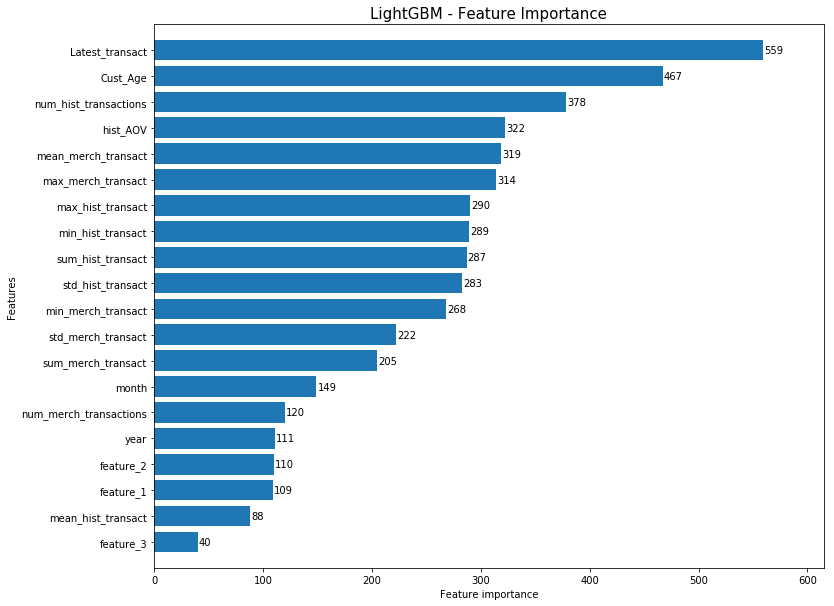

In [55]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()